# Semi-supervised učení

Při učení s učitel potřebujeme mnoho označkovaných dat (dat, u kterých známe cílovou třídu, nebo hodnotu). Získání označkovaných dat je ale často nákladné, typickým příkladem jsou různé fonetické přepisy textu, kde se uvádí, že na jednu hodinu textu je třeba až 400 hodin práce na přepisování. Proto by se hodilo k učení kromě označkovaných dat používat i data neoznačkovaná, která se získávají mnohem snáze. A právě využitím neoznačkových dat v učení s učitelem se zabývá semi-supervised učení.

Podobnou metodou je i trasnduktivní učení, jeho cílem ale je ohodnotit jen neoznačkovaná data, která jsou dostupná během trénování. Semi-supervised učení by mělo být induktivní, tj. aplikovatelné i na úplně nová data.

Některé z metod, o kterých už jsme se na semináři bavili mohou využít i neoznačkovaná data, např. Stacked Auto-encoders používají v první fázi učení bez učitele a nic nám nebrání použít neoznačkovaná data. Podobně RBF sítě, které používají klastrování k nalezení pozic středů jednotlivých jednotek mohou využít i neoznačkovaná data. 

## Self-learning

Základní myšlenka self-learning je jednoduchá, předpokládá se, že předpovědi, kterými si je model jistý jsou správné. Model se tedy natrénuje na označkovaných datech a ohodnotí se neoznačkovaná data. Podíváme se na jistotu předpovédi (model ji musí umět nějak vyjádřít) a data, kterými si je model nejjistější přidáme do trénovací množiny i s předpověďma, které pro ně model udělal. Tento postup opakujeme, dokud chceme.

Největším problémem self-learningu je, že chyby, které model udělá na začátku mohou hodně ovlivnit výsledek modelu, protože se je model učí jako správné předpovědi. Tomu se dá trochu zabránit tak, že z trénovací množiny naopak odstraňujeme vzorky, kterými si model není moc jistý (jen ty, které původně byly neoznačkované).

C:\Anaconda3\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


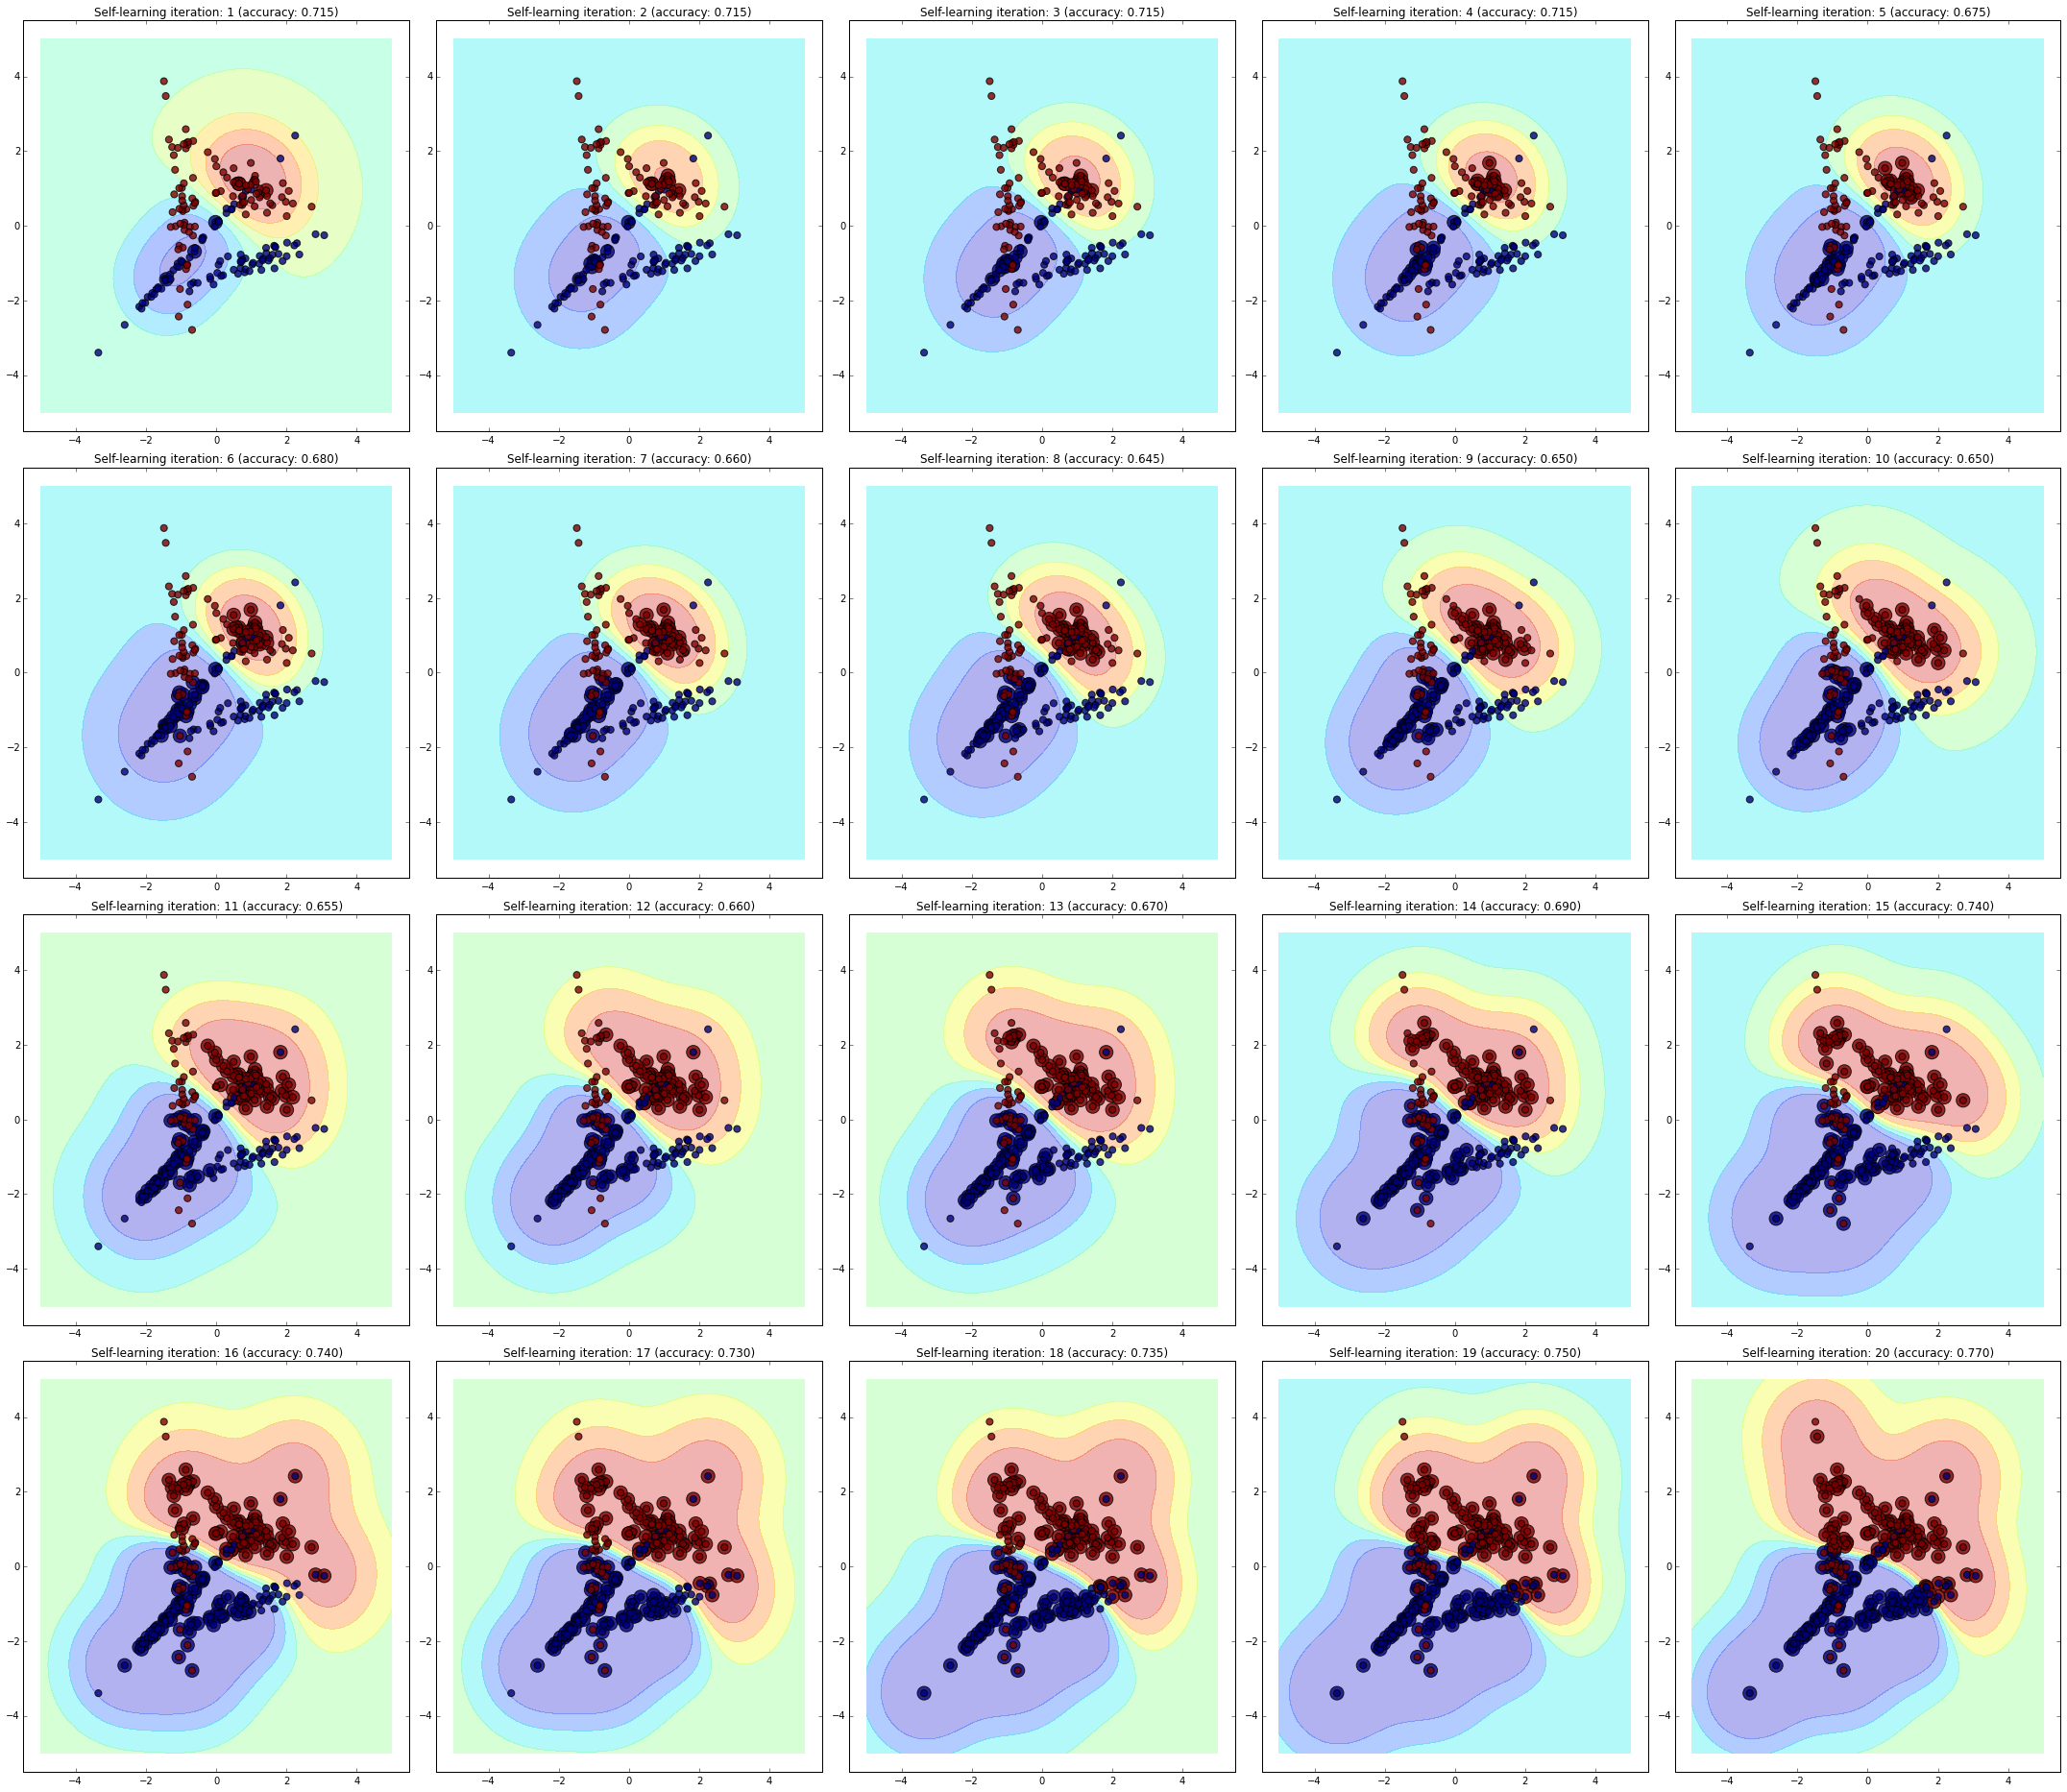

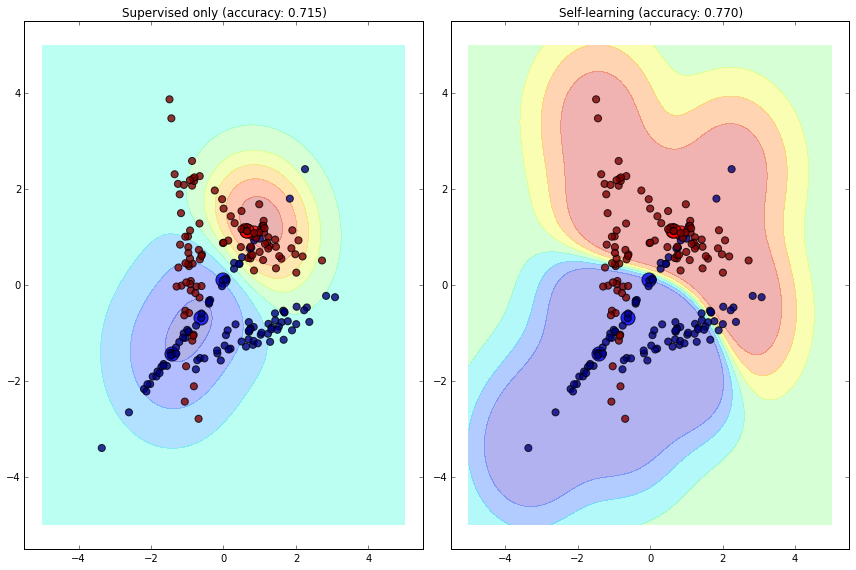

In [120]:
from sklearn import datasets, svm, metrics
import numpy as np

#vyrobima mesh pro vizualizaci
XX, YY = np.meshgrid(np.linspace(-5, 5, 500), np.linspace(-5, 5, 500))
points = np.array([XX.ravel(), YY.ravel()]).T

# vyrobime data pro klasifikaci
X, y = datasets.make_classification(n_classes=2, n_informative=2, n_features=2, n_redundant=0, n_samples=200, shuffle=False)
y_true = y

# nechame jen 3 oznackovane vzory z kazde tridy
y = -np.ones(y.shape)
y[0:3] = np.zeros(3)
y[-3:] = np.ones(3) 

# oddelime oznackovana data
X_labeled = np.vstack((X[:3], X[-3:]))
y_labeled = np.hstack((y[:3], y[-3:]))

# zbytek je nezonackovany
X_unlabeled = X[3:-3]

# natrenujeme SVC jen na oznackovanych datech
sup_svm = svm.SVC(probability=True, kernel='rbf')
sup_svm.fit(X_labeled, y_labeled)

plt.figure(figsize=(30,26))
# natrenujeme SVC pomoci self-learningu
for i in range(20):
    self_svm = svm.SVC(probability=True, kernel='rbf')
    self_svm.fit(X_labeled, y_labeled)
    ax = plt.subplot(4, 5, i+1)
    preds = self_svm.predict_proba(points)
    ax.contourf(XX, YY, preds[:, 1].reshape(XX.shape), alpha=0.3)
    ax.scatter(X_labeled[:,0], X_labeled[:, 1], c=y_labeled, s=200, alpha=0.8)
    ax.scatter(X[:,0], X[:, 1], c=y_true, s=50, alpha=0.8)
    accuracy = metrics.accuracy_score(y_true, self_svm.predict(X))
    ax.set_title('Self-learning iteration: %d (accuracy: %.3f)' % (i+1,accuracy))
    preds = self_svm.predict_proba(X_unlabeled)
    sort_idx = np.argsort(preds[:, 0])
    prob_zeros = X_unlabeled[sort_idx[-5:]]
    prob_ones = X_unlabeled[sort_idx[:5]]
    new_X_labels = np.vstack((prob_zeros, prob_ones))
    new_y_labels = np.array([0]*5+[1]*5)
    X_labeled = np.vstack((X_labeled, new_X_labels))
    y_labeled = np.hstack((y_labeled, new_y_labels))
    X_unlabeled = X_unlabeled[sort_idx[5:-5]]

plt.tight_layout()
plt.show()
# a tady self-learning konci
    
# spocitame predikce obou SVC
sup_svm_pred = sup_svm.predict_proba(points)
self_svm_pred = self_svm.predict_proba(points)

# nakreslime vysledky
plt.figure(figsize=(12,8))
ax = plt.subplot(1, 2, 1)
ax.contourf(XX, YY, sup_svm_pred[:, 1].reshape(XX.shape), alpha=0.3)
ax.scatter(X[0:3,0], X[0:3, 1], c='blue', s=200, alpha=0.8)
ax.scatter(X[-4:-1,0], X[-4:-1, 1], c='red', s=200, alpha=0.8)
ax.scatter(X[:,0], X[:, 1], c=y_true, s=50, alpha=0.8)
accuracy = metrics.accuracy_score(y_true, sup_svm.predict(X))
ax.set_title('Supervised only (accuracy: %.3f)' % accuracy)

ax = plt.subplot(1, 2, 2)
ax.contourf(XX, YY, self_svm_pred[:, 1].reshape(XX.shape), alpha=0.3)
ax.scatter(X[0:3,0], X[0:3, 1], c='blue', s=200, alpha=0.8)
ax.scatter(X[-4:-1,0], X[-4:-1, 1], c='red', s=200, alpha=0.8)
ax.scatter(X[:,0], X[:, 1], c=y_true, s=50, alpha=0.8)
accuracy = metrics.accuracy_score(y_true, self_svm.predict(X))
ax.set_title('Self-learning (accuracy: %.3f)' % accuracy)

plt.tight_layout()
plt.show()

## Co-learning

S podobnou myšlenkou jako u self-learningu se pracuje i v co-learningu, ale tady se předpokládá, že ke každému vzorku máme příznaky nějakých dvou typů (např. při klasifikaci obrázků z webových stránek můžeme kromě obrázku mít i nějaký okolní text, potom extrahujeme nějaké příznaky z obrázku a nějaké z textu). Jednou možností by bylo vektory příznaků spojit do jednoho dlouhého vektoru a učit běžným způsobem model. 

Co-learning ale v tomto případě funguje trochu jinak. Pro každou množinu příznaků se trénuje jeden model (tj. v našem příkladě jeden model pro klasifikaci na základě textu a jeden pro klasifikaci na základě obrázku). Oba modely se napřed natrénují na označkovaných datech, potom se nechají předpovědět neoznačkovaná data oběma modely a data, kterými si je nejjistější první model se přidají s předpověďmi prvního modelu, do trénovací množiny druhého modelu. Data, kterými si je jistý druhý model se naopak přidají do trénovací množiny prvního modelu. Tento postup se zase opakuje, dokud chceme.

## Grafové metody

V grafových metodách se typicky spočítají vzdálenosti mezi všemi dvojicemi dat (označkovaných i neoznačkovaných) a z nich se udělá graf (je také možné udělat graf, kde hrany vedou jen k nejbližším sousedům). Hlavní motivace je vidět na následujícím obrázku ![](similar.png)

První a poslední symbol si nejsou přímo moc podobné, ale když se mezi ně vloží další symboly, tak je vidět, že mezi nimi nejspíš nějaká podobnost je. Můžeme si představovit, že první a poslední symbol jsou označkované a symboly mezi nimi ne.

Odvození značek pro nová data se v grafových metodách dá dělat několika způsoby. Při binární klasifikaci se například dá použít technika nejmenšího řezu, kdy se optimalizuje funkce $$\sum_{ij}w_{ij}|y_i-y_j|.$$ Další možností je využití harmonické funkce. Po té chceme, aby $f(x_i)=y_i$ pro označkované vzory a aby minimalizovala energii $$\sum_{i\sim j}(f(x_i)-f(x_j))^2,$$ kde $i \sim j$ znamená, že $i$ a $j$ jsou sousedi. Tato funkce má několik zajímavých interpretací, jedna z nich je, že $f(x) = P(\mathrm{napřed~dojdu~do~1}| \mathrm{vyjdu~z~}x)$ při náhodné procházce po grafu, kde se další vrchol vybírá ze sousedů s pravděpodností uměrnou jejich podobnosti. Harmonická funkce se dá najít iterativně tak, že se napřed všem označeným vrcholům přiřadí jejich hodnota a potom se pro neoznačené vrcholy opakuje $$f(x_i) = \frac{\sum_{j\sim i}w_{ij}f(x_j)}{\sum_{j \sim i}w_{ij}}.$$

Nevýhodou použití harmonické funkce je, že se těžko rozšiřuje na nová testovací data. V zásadě je potřeba pro nová data harmonickou funkci přepočítat, protože se změní celý graf.

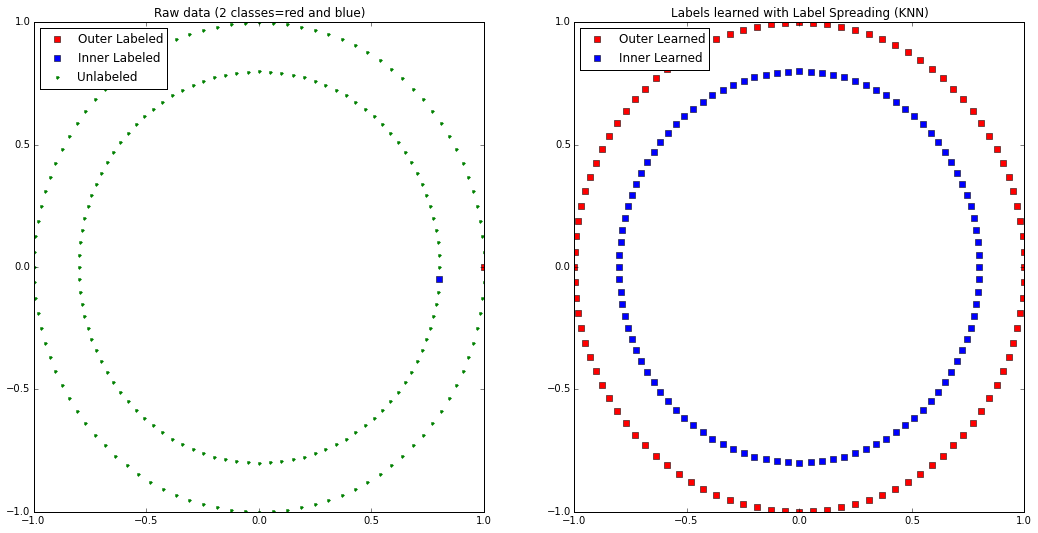

In [122]:
# prevzato z http://scikit-learn.org/stable/auto_examples/semi_supervised/plot_label_propagation_structure.html#example-semi-supervised-plot-label-propagation-structure-py
# Authors: Clay Woolam <clay@woolam.org>
#          Andreas Mueller <amueller@ais.uni-bonn.de>
# Licence: BSD

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.semi_supervised import label_propagation
from sklearn.datasets import make_circles

# generate ring with inner box
n_samples = 200
X, y = make_circles(n_samples=n_samples, shuffle=False)
outer, inner = 0, 1
labels = -np.ones(n_samples)
labels[0] = outer
labels[-1] = inner

###############################################################################
# Learn with LabelSpreading
label_spread = label_propagation.LabelSpreading(kernel='knn', alpha=1.0)
label_spread.fit(X, labels)

###############################################################################
# Plot output labels
output_labels = label_spread.transduction_
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_outer_labeled, = plt.plot(X[labels == outer, 0],
                               X[labels == outer, 1], 'rs')
plot_unlabeled, = plt.plot(X[labels == -1, 0], X[labels == -1, 1], 'g.')
plot_inner_labeled, = plt.plot(X[labels == inner, 0],
                               X[labels == inner, 1], 'bs')
plt.legend((plot_outer_labeled, plot_inner_labeled, plot_unlabeled),
           ('Outer Labeled', 'Inner Labeled', 'Unlabeled'), loc='upper left',
           numpoints=1, shadow=False)
plt.title("Raw data (2 classes=red and blue)")

plt.subplot(1, 2, 2)
output_label_array = np.asarray(output_labels)
outer_numbers = np.where(output_label_array == outer)[0]
inner_numbers = np.where(output_label_array == inner)[0]
plot_outer, = plt.plot(X[outer_numbers, 0], X[outer_numbers, 1], 'rs')
plot_inner, = plt.plot(X[inner_numbers, 0], X[inner_numbers, 1], 'bs')
plt.legend((plot_outer, plot_inner), ('Outer Learned', 'Inner Learned'),
           loc='upper left', numpoints=1, shadow=False)
plt.title("Labels learned with Label Spreading (KNN)")

plt.subplots_adjust(left=0.07, bottom=0.07, right=0.93, top=0.92)
plt.show()

## Generativní modely

V generativních modelech se dají neoznačkovaná data také využít. Dají se přímo započítat do pravděpodností, které tyhle modely typicky využívají. Místo $P(X, y| \theta)$ se typicky počítá $P(X, y, X_u | \theta)$, kde $P(X, y, X_u | \theta) = \sum_{y_u}P(X, y, X_u, y_u | \theta)$. A to je vlastně všechno, potom se zvolí nějaká metoda odhadu parametrů $\theta$ (např. Maximum Likelihood Estimation, EM algoritmus, ...) a parametry se určí. Například pro směs Gaussovských modelů máme v normálním (supervised) případě $$\log P(X_l, Y_l, | \theta) = \sum_{i=1}^l \log p(y_i | \theta) \log p(x_i|y_i, \theta)$$ a odhad $\theta$ je jednoduchý přímo z dat (četnosti, průměry a kovariance). V případě, že máme i neoznačkovaná data, dostáváme o něco složitější výraz $$\log p(X_l, Y_l, X_u | \theta) = \sum_{i=1}^l \log p(x_i|y_i, \theta) + \lambda\sum_{i=l+1}^{l+u} \log(\sum_{y=1}^2p(y|\theta)p(x_i|y, \theta))$$ a pro řešení tohoto problému se dá použít EM algoritmus.

## Semi-supervised SVM (S3VM)

Semi-supervised SVM (S3VM, nebo TSVM od Transductive SVM) maximalizuje margin i na neoznačkovaných datech. Zajímavé je, že toho dosahuje tím, že vyzkouší všechna možná přiřazení cílových tříd k neoznačeným datům a vybere se to, které maximalizuje margin. Vyzkoušení všech přiřazení postupně by trvalo dlouho, tento problém se řeší tak, že se přidají nové podmínky do optimalizace, které právě tato přiřazení zkouší. Cenou za "zkoušení" tedy je to, že za každou neoznačenou instanci z dat máme dvě nové podmínky. Celý optimalizační problém v S3VM tedy má následující tvar ![](S3VM.png)

Hlavní nevýhodnou S3VM je, že optimalizace, kterou je třeba provést, je složitější než u běžných SVM (nejen kvůli tomu, že máme víc podmínek, ale i kvůli tomu, že problém není konvexní) a trénování tak trvá déle. Místo použití popsaného přístupu se tak často volí jiné heuristické postupy, jako např. branch-and-bound (strom se staví tak, že se postupně ohodnocují neoznačkované vzory), nebo se napřed natrénuje SVM na označkovaných datech, podle toho se určí první odhady neoznačkovaných dat a potom se zkouší, jestli nejde měnit ohodnocení neoznačkovaných dat po dvojicích tak, aby se zmenšila chyba, pokud to jde, provede se nová optimalizace. Výhoda tohoto přístupu je, že si můžeme říct, kolik neoznačkovaných dat má patřit do jaké třídy.

Pěkné povídaní o TSVM jde najít i [tady](https://charlesmartin14.wordpress.com/2014/09/23/machine-learning-with-missing-labels-transductive-svms/).

S3VM jsou implementované v knihovně [semisup-learn](https://github.com/tmadl/semisup-learn), ale nepodařilo se mi implementaci upravit pro Python 3, tak aby fungovaly i obrázky z příkladů (jinak s 2to3 jde metody pustit i v Pythonu 3), tak se podíváme jen na obrázek ([CPLE](http://arxiv.org/pdf/1503.00269v2.pdf) je relativně nová metoda odhadu parametrů, která zajišťuje, že výsledek nebude horší než v čistě supervised případě).
![](svmexample1.png)
![](svmexample2.png)